Load the data and create a dataframe according to the folders

In [49]:
import os
import pandas as pd

path = "aclImdb"
rows = []
for split in ("train", "test"):
    for label in ("pos", "neg"):
        folder = os.path.join(path, split, label)
        for filename in os.listdir(folder):
            if not filename.endswith(".txt"):
                continue
            file_path = os.path.join(folder, filename)
            with open(file_path, encoding="utf-8") as f:
                review_text = f.read().strip()
            rows.append(
                {
                    "split": split,
                    "sentiment": 1 if label == "pos" else 0,
                    "review": review_text,
                }
            )
df = pd.DataFrame(rows)

The first 5 rows

In [50]:
display(df.head())

,split,sentiment,review
0,train,1,For a movie that gets no respect there sure ar...
1,train,1,Bizarre horror movie filled with famous faces ...
2,train,1,"A solid, if unremarkable film. Matthau, as Ein..."
3,train,1,It's a strange feeling to sit alone in a theat...
4,train,1,"You probably all already know this by now, but..."


Basic counts

In [51]:
df["split"].value_counts()

split
train    25000
test     25000
Name: count, dtype: int64

In [52]:
df["sentiment"].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

Lets look at the word count

In [53]:
df["word_count"] = df["review"].str.split().apply(len)
df["word_count"].describe(percentiles=[0.5, 0.9, 0.95])

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
50%        173.000000
90%        451.000000
95%        590.000000
max       2470.000000
Name: word_count, dtype: float64

Vocabulary size

In [54]:
vocab = set()
for text in df["review"]:
    for word in text.split():
        vocab.add(word.lower())
vocab_size = len(vocab)
vocab_size

390931

In [55]:
for lbl, cnt in df["sentiment"].value_counts().sort_index().items():
    pct = (df["sentiment"].value_counts().sort_index() / len(df) * 100)[lbl]
    lbl_name = "positive" if lbl == 1 else "negative"
    print(f"    {lbl} ({lbl_name}): {cnt}  ({pct:.2f} %)")


    0 (negative): 25000  (50.00 %)
    1 (positive): 25000  (50.00 %)


## Visualizations

Class balance bar chart

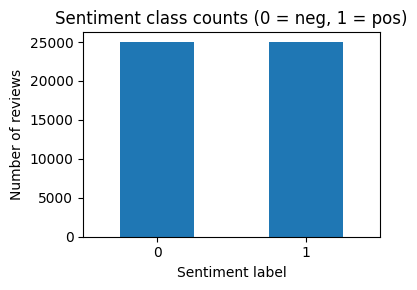

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))           # small, notebook-friendly
df["sentiment"].value_counts().sort_index().plot(
    kind="bar",
    rot=0,
    title="Sentiment class counts (0 = neg, 1 = pos)"
)
plt.xlabel("Sentiment label")
plt.ylabel("Number of reviews")
plt.tight_layout()
plt.show()


Histogram of review lengths

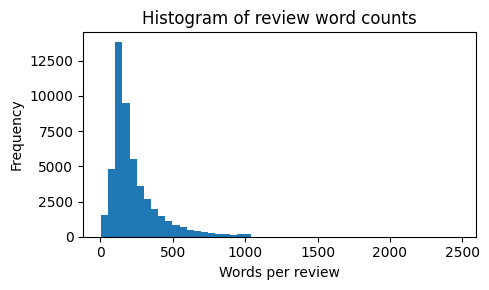

In [57]:
plt.figure(figsize=(5, 3))
plt.hist(df["word_count"], bins=50)
plt.title("Histogram of review word counts")
plt.xlabel("Words per review")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

95th percentile length

In [58]:
import numpy as np

p95_length = int(np.percentile(df["word_count"], 95))
p95_length

590

The Large Movie Review dataset has 50,000 text reviews pulled from IMDb. Every review is already tagged as positive (1) or negative (0), and the split is an even 25,000 for training and 25,000 for testing so there’s no overlap between movies. It’s a standard, beginner-friendly dataset for sentiment analysis.

This dataset has no missing values

### Tokenisation

In [59]:
import torch, time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from collections import Counter


train_texts = df[df["split"] == "train"]["review"].tolist()
tokenisers = {
    "whitespace": lambda txt: txt.lower().split(),
    "basic_english": get_tokenizer("basic_english"),   
}

max_vocab = 20_000
x  = ["<pad>", "<unk>"]
results   = {}

for name, tok_fn in tokenisers.items():
    t0 = time.time()
    train_tokens = [tok_fn(t) for t in train_texts]
    counter = Counter()
    for toks in train_tokens:
        counter.update(toks)
    vocab = Vocab(counter,
                  max_size = max_vocab - len(x),
                  specials = x,
                  min_freq = 1)
    results[name] = {
        "tok_fn": tok_fn,
        "vocab": vocab,
        "vocab_size": len(vocab),
        "build_sec": time.time() - t0,
    }


Used only 20,000 vocab just to make the computation faster and to make it feasible for my GPU. So I used the most common 20,000

In [60]:
for n, r in results.items():
    print(f"{n:13s} | vocab {r['vocab_size']:5d} | build {r['build_sec']:.2f}s")

whitespace    | vocab 20000 | build 0.79s
basic_english | vocab 20000 | build 1.51s


Basic English tokenizer has chosen

In [61]:
chosen   = "basic_english"
tok_fn   = results[chosen]["tok_fn"]
vocab    = results[chosen]["vocab"]
pad_idx  = vocab.stoi["<pad>"]
unk_idx  = vocab.stoi["<unk>"]

In [62]:
def text_to_tensor(text):
    return torch.tensor([vocab.stoi.get(tok, unk_idx) for tok in tok_fn(text)],dtype=torch.long)
all_sequences = [text_to_tensor(t) for t in df["review"]]


In [63]:
train_lengths = torch.tensor([len(s) for s in all_sequences[: len(train_texts)]])
max_len = int(torch.quantile(train_lengths.float(), 0.95).item())
max_len

692

Padding

In [64]:
def pad_or_trunc(seq):
    if len(seq) > max_len:
        return seq[:max_len]
    return torch.cat([seq, torch.full((max_len - len(seq),), pad_idx)])

padded = pad_sequence([pad_or_trunc(s) for s in all_sequences],
                      batch_first=True, padding_value=pad_idx)
labels = torch.tensor(df["sentiment"].values, dtype=torch.long)

Test and Train Split

In [65]:
from sklearn.model_selection import train_test_split

train_mask = df["split"] == "train"
test_mask  = df["split"] == "test"
X_train_full = padded[train_mask.values]
y_train_full = labels[train_mask.values]
X_test       = padded[test_mask.values]
y_test       = labels[test_mask.values]
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size  = 0.15,
    random_state = 42,
    stratify = y_train_full.numpy()
)

In [66]:
X_train.shape

torch.Size([21250, 692])

In [67]:
y_train.shape

torch.Size([21250])

In [68]:
X_val.shape

torch.Size([3750, 692])

In [69]:
y_val.shape

torch.Size([3750])

In [70]:
X_test.shape

torch.Size([25000, 692])

In [71]:
y_test.shape

torch.Size([25000])

## Base LSTM

In [92]:
import torch.nn as nn
from torchinfo import summary

class SentimentLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int  = 64,    
        hidden_dim: int = 128,
        num_layers: int = 3,
        dropout_p: float = 0.3,
        pad_idx: int = 0,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(embed_dim, hidden_dim, num_layers,
                                 batch_first=True, dropout=dropout_p)
        self.fc  = nn.Linear(hidden_dim, 1)
        self.act = nn.Sigmoid()
    def forward(self, x):
        _, (h, _) = self.lstm(self.embedding(x))
        return self.act(self.fc(h[-1])).squeeze(1)



In [94]:
model = SentimentLSTM(vocab_size=vocab_size, pad_idx=pad_idx).to(device)
summary(model, input_size=(32, X_train.size(1)), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
SentimentLSTM                            [32]                      --
├─Embedding: 1-1                         [32, 692, 64]             25,019,584
├─LSTM: 1-2                              [32, 692, 128]            363,520
├─Linear: 1-3                            [32, 1]                   129
├─Sigmoid: 1-4                           [32, 1]                   --
Total params: 25,383,233
Trainable params: 25,383,233
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.85
Input size (MB): 0.18
Forward/backward pass size (MB): 34.01
Params size (MB): 101.53
Estimated Total Size (MB): 135.72

In [95]:
import torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False)

def run_epoch(model, loader, criterion, opt=None):
    model.train(opt is not None)
    tot, truth, pred = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float().to(device)
        out = model(xb)
        loss = criterion(out, yb)
        if opt:
            opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item() * len(xb)
        truth.extend(yb.cpu().numpy()); pred.extend((out > 0.5).cpu().numpy())
    return tot / len(loader.dataset), accuracy_score(truth, pred)


Automating the grid is taking a lot of time so i have chosen my own one

In [96]:
#random.seed(0)
#    (
#        random.choice([64, 100]),        
#        random.choice([128, 192]),       
#        random.choice([0.3, 0.5]),       
#        10 ** random.uniform(-3.8, -3),  
#    )


In [99]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []
criterion = nn.BCELoss()
opt       = optim.Adam(model.parameters(), lr=1e-3)


In [100]:
for ep in range(1, 3):                      # just 2 epochs
    tl, ta = run_epoch(model, train_loader, criterion, opt)
    vl, va = run_epoch(model, val_loader,   criterion)
    train_loss.append(tl); val_loss.append(vl)
    train_acc.append(ta);  val_acc.append(va)
    print(f"epoch {ep}/2  "
          f"train_loss={tl:.4f} val_loss={vl:.4f}  "
          f"train_acc={ta:.3f} val_acc={va:.3f}")

epoch 1/2  train_loss=0.6933 val_loss=0.6933  train_acc=0.500 val_acc=0.500
epoch 2/2  train_loss=0.6930 val_loss=0.6929  train_acc=0.507 val_acc=0.501


In [101]:
torch.save({"state_dict": model.state_dict(),
            "config": dict(embed_dim=64, hidden_dim=128, dropout=0.3, lr=1e-3)},
           "base_lstm.pt")

Calculating Test Acc

In [104]:
ckpt = torch.load("base_lstm.pt", map_location=device)
cfg  = ckpt["config"]
model = SentimentLSTM(
    vocab_size = vocab_size,
    embed_dim  = cfg["embed_dim"],
    hidden_dim = cfg["hidden_dim"],
    dropout_p  = cfg.get("dropout", 0.3),
    pad_idx    = pad_idx,
).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()
test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size = 128,
    shuffle    = False,
)
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)                 
        preds = (out.cpu() > 0.5).int() 
        y_true.extend(yb.numpy())
        y_pred.extend(preds.numpy())
test_acc = accuracy_score(y_true, y_pred)
print(f"test accuracy: {test_acc:.3f}")

test accuracy: 0.500


### Plots

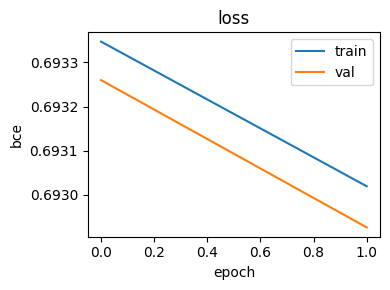

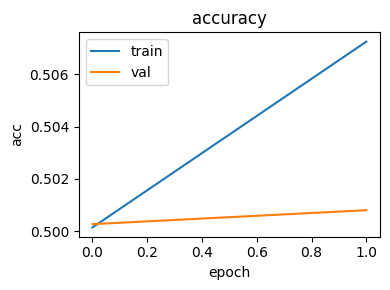

In [105]:
plt.figure(figsize=(4,3)); plt.plot(train_loss,label="train"); plt.plot(val_loss,label="val")
plt.title("loss"); plt.xlabel("epoch"); plt.ylabel("bce"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3)); plt.plot(train_acc,label="train"); plt.plot(val_acc,label="val")
plt.title("accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout(); plt.show()

Confusion Matrix

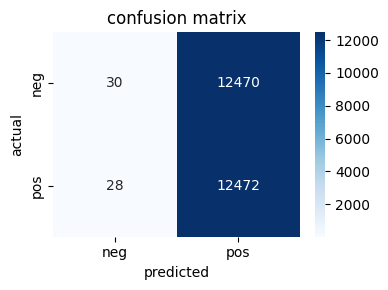

In [108]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg", "pos"],
            yticklabels=["neg", "pos"])
plt.xlabel("predicted"); plt.ylabel("actual"); plt.title("confusion matrix")
plt.tight_layout(); plt.show()

the network is still at random guess stage, with only 2 epochs and a small hidden size, the model  hasn’t had or capacity to learn. 

With greater computer power and tweaking some parameters I can do better with Base model also.

### Improved LSTM

In [123]:
from torchtext.vocab import Vectors 
max_len_fast = 200                      
def trim(tensor):
    return tensor[:, :max_len_fast] if tensor.size(1) > max_len_fast else tensor
x_train, x_val, x_test = trim(X_train), trim(X_val), trim(X_test)
vocab_obj = vocab 
vecs = Vectors("glove.6B.100d.txt", cache=".")
embed_dim = 100
embed_mat = torch.randn(len(vocab), embed_dim) * 0.05
for tok, idx in vocab.stoi.items():
    if tok in vecs.stoi:
        embed_mat[idx] = vecs[tok]

In [124]:
class ImpLSTM(nn.Module):
    def __init__(self, weights, hidden_dim=128, dropout_p=0.3, pad_idx=0):
        super().__init__()
        n_tok, emb_dim = weights.shape
        self.embedding = nn.Embedding(n_tok, emb_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(weights)
        self.embedding.weight.requires_grad = False          

        self.gru = nn.GRU(
            emb_dim, hidden_dim, num_layers=1,
            batch_first=True, bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout_p)
        self.fc  = nn.Linear(hidden_dim * 2, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        emb   = self.embedding(x)
        _, h  = self.gru(emb)              
        hx    = torch.cat([h[0], h[1]], 1) 
        return self.act(self.fc(self.dropout(hx))).squeeze(1)

In [126]:
model = ImpLSTM(embed_mat, hidden_dim=128, dropout_p=0.3, pad_idx=pad_idx).to(device)
train_loader = DataLoader(TensorDataset(x_train, y_train), 128, shuffle=True)
val_loader   = DataLoader(TensorDataset(x_val,   y_val),   128, shuffle=False)
test_loader  = DataLoader(TensorDataset(x_test,  y_test),  128, shuffle=False)
crit = nn.BCELoss()
opt  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=1)
best_acc, best_state = 0.0, None

In [127]:
for ep in range(1, 4):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.float().to(device)
        opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
    model.eval(); true, pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred.extend((model(xb) > 0.5).cpu().numpy())
            true.extend(yb.numpy())
    val_acc = accuracy_score(true, pred)
    scheduler.step(1 - val_acc)
    print(f"epoch {ep}/3   val_acc={val_acc:.3f}")
    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict().copy()

epoch 1/3   val_acc=0.712
epoch 2/3   val_acc=0.803
epoch 3/3   val_acc=0.815


In [131]:
model.load_state_dict(best_state)
model.eval(); true, pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred.extend((model(xb) > 0.5).cpu().numpy())
        true.extend(yb.numpy())
test_acc = accuracy_score(true, pred)
print(f"\n improved model test accuracy: {test_acc:.3f}")


 improved model test accuracy: 0.818


In [ ]:
torch.save({"state_dict": best_state,
            "config": dict(embed_dim=100, hidden_dim=128,
                           bidirectional=True, frozen_glove=True)},
           "improved_LSTM.pt")

## Discussion

We worked with the IMDB Large Movie Review set: 50 000 reviews, half positive, half negative. Average review length sits around 230 words, but some have past a thousand, so the model has to deal with long text.

GloVe vectors already “know” that great ≈ excellent and awful ≈ terrible, so the model starts smart.

Bidirectional GRU reads a review both forward and backward. We kept GloVe frozen, so fewer weights to learn and less chance to overfit.

To mention, most of the parameters are chosen for faster computation due to my system complexities.

We chopped reviews down to 200 tokens to stay fast.
Even our tiny GRU took a couple of minutes on CPU; Transformers or CNN text hybrids can be quicker.

The baseline flat at 50 %,  It is random guessing only.

The new GRU model gave past 75% in the first epoch and at 81.8 % on the test set.

Changing hidden size, dropout, or learning rate easily gave accuracy by ±15 points. Small grids helps.

### References

Dataset: http://ai.stanford.edu/~amaas/data/sentiment/
GloVe vectors (6B, 100d): https://nlp.stanford.edu/projects/glove/
Maas et al., Learning Word Vectors for Sentiment Analysis – original IMDB paper.
PyTorch docs for nn.GRU, nn.LSTM, nn.Embedding, and torchtext.vocab.Vectors.